### Inference Model Denoising & Classification


In [25]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from AdaptiveFilterWrapper import adapfilt_modeler

In [2]:
def read_adapfilt_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model

- load model

In [17]:
lms_model = read_adapfilt_model("LMS_adapfilt_model_afdb.pkl")
nlms_model = read_adapfilt_model("NLMS_adapfilt_model_afdb.pkl")
rls_model = read_adapfilt_model("RLS_adapfilt_model_afdb.pkl")

In [18]:
cnn_lms_model = models.load_model('CNN_Classification_model_lms.h5')
cnn_nlms_model = models.load_model('CNN_Classification_model_nlms.h5')
cnn_rls_model = models.load_model('CNN_Classification_model_rls.h5')

In [52]:
label_names = ['AF', 'N']

In [19]:
dataset_folder ="dataset/"
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_pasien_") > -1:
        filenames.append(filename)

In [20]:
filenames

['AFDB_pasien_AF_Ibu EEM.csv',
 'AFDB_pasien_AF_Ibu Halima.csv',
 'AFDB_pasien_AF_Ibu Yaya.csv',
 'AFDB_pasien_AF_Pak Dawin.csv',
 'AFDB_pasien_AF_Pak Ohan.csv',
 'AFDB_pasien_AF_Pak Wardoyo.csv',
 'AFDB_pasien_Normal_Fikar.csv',
 'AFDB_pasien_Normal_Imam.csv',
 'AFDB_pasien_Normal_Putu.csv']

- load inference data

In [21]:
inference_data = {}
for name in filenames:
    infer = pd.read_csv(dataset_folder + name, header=None)
    inference_data[name] = infer

In [22]:
inference_data['AFDB_pasien_AF_Ibu EEM.csv'].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.735847,0.810470,0.834570,0.817344,0.775643,0.728654,0.691847,0.674867,0.678770,0.697589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000651,1.078669,1.075988,1.005982,0.894077,0.770221,0.660691,0.582774,0.541611,0.531473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.349208,0.383967,0.394341,0.384677,0.363018,0.338588,0.318951,0.308876,0.309087,0.316957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.332000,0.365133,0.375185,0.366316,0.346175,0.323504,0.305442,0.296430,0.297050,0.304702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.372790,0.390878,0.372805,0.323730,0.254204,0.177298,0.105398,0.047643,0.008490,-0.012247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
mat_infer_data = {}
for name in filenames:
    infer_df = inference_data[name]
    mat_infer_data[name] = infer_df.values

- Apply denoising model to inference data

In [37]:
lms_den_res = {}
nlms_den_res = {}
rls_den_res = {}
for name in filenames:
    lms_den_res[name] = lms_model.transform(mat_infer_data[name])
    nlms_den_res[name] = nlms_model.transform(mat_infer_data[name])
    rls_den_res[name] = rls_model.transform(mat_infer_data[name])

In [38]:
def plot_denoising_test(y, x, model='lms'):
    # show results
    plt.figure(figsize=(6,4))
    plt.title("Adaptation Result %s - Inference Dataset" % model.upper())
    plt.xlabel("samples - n")
    plt.plot(y,"b", label="y - denoised signal")
    plt.plot(x,"g", label="x - original signal")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

- Check result

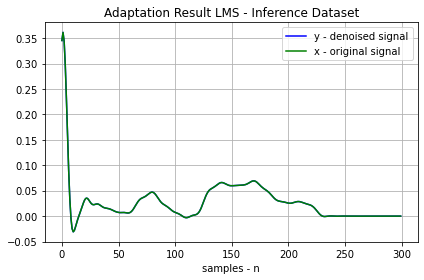

In [39]:
name = 'AFDB_pasien_AF_Ibu EEM.csv'
idx = 13

y = lms_den_res[name][idx]
x = mat_infer_data[name][idx]

plot_denoising_test(y, x, model='lms')

- Reshape matrix result of denoising

In [49]:
lms_mat_3d = {}
nlms_mat_3d = {}
rls_mat_3d = {}
for name in filenames:
    lms_mat_3d[name] = lms_den_res[name].reshape(len(lms_den_res[name]), lms_den_res[name].shape[1], 1)
    nlms_mat_3d[name] = nlms_den_res[name].reshape(len(nlms_den_res[name]), nlms_den_res[name].shape[1], 1)
    rls_mat_3d[name] = rls_den_res[name].reshape(len(rls_den_res[name]), rls_den_res[name].shape[1], 1)


- Apply to CNN model

In [51]:
cnn_lms_classif_result = {}
cnn_nlms_classif_result = {}
cnn_rls_classif_result = {}
for name in filenames:
    cnn_lms_classif_result[name] = cnn_lms_model.predict(lms_mat_3d[name])
    cnn_nlms_classif_result[name] = cnn_nlms_model.predict(nlms_mat_3d[name])
    cnn_rls_classif_result[name] = cnn_rls_model.predict(rls_mat_3d[name])

- Check result

In [55]:
def plot_cnn_result(data, label='lms', confidence=0.0):
    confidence = confidence*100
    # show results
    plt.figure(figsize=(6,4))
    plt.title("Classification Result : %s - confidence (%.2f%%)" % (label, confidence))
    plt.xlabel("samples - n")
    plt.plot(data,"g", label="signal")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

In [75]:
cnn_pred_result = []
for name in filenames :
    cnn_res = cnn_lms_classif_result[name]
    print("\n\n\nPrediction Result - %s\n" % name)
    for i, res in enumerate(cnn_res):
        predicted_id = np.argmax(res)
        label = label_names[predicted_id]
        confidence = res[predicted_id]
        label = label if confidence > 0.70 else '?' # threshold for confidence level , set to 70%
        cnn_pred_result.append([name, i, label, confidence])
        
        print('%s \t index - %d \t %s \t %.2f %%' % (name, i, label, confidence*100))




Prediction Result - AFDB_pasien_AF_Ibu EEM.csv

AFDB_pasien_AF_Ibu EEM.csv 	 index - 0 	 AF 	 87.19 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 1 	 N 	 74.31 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 2 	 ? 	 69.95 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 3 	 ? 	 62.76 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 4 	 AF 	 78.52 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 5 	 ? 	 56.48 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 6 	 AF 	 74.14 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 7 	 AF 	 94.55 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 8 	 AF 	 98.22 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 9 	 AF 	 87.42 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 10 	 ? 	 60.64 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 11 	 AF 	 95.77 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 12 	 ? 	 58.51 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 13 	 AF 	 94.99 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 14 	 AF 	 93.91 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 15 	 AF 	 87.44 %
AFDB_pasien_AF_Ibu EEM.csv 	 index - 16 	 N 	 99.85 %
AFDB_pasien_AF_Ibu EEM.csv 	 in

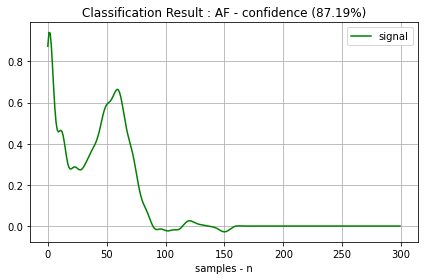

In [83]:
res = cnn_pred_result[0]
data = lms_den_res[name][res[1]]
plot_cnn_result(data, res[2], res[3])

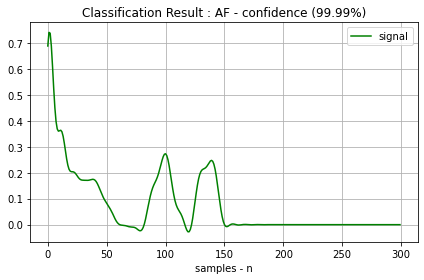

In [89]:
res = cnn_pred_result[-6]
data = lms_den_res[name][res[1]]
plot_cnn_result(data, res[2], res[3])

In [95]:
pred_result_df = pd.DataFrame(cnn_pred_result, columns=['filename', 'idx', 'label', 'confidence'])

In [96]:
pred_result_df.head()

,filename,idx,label,confidence
0,AFDB_pasien_AF_Ibu EEM.csv,0,AF,0.871926
1,AFDB_pasien_AF_Ibu EEM.csv,1,N,0.743064
2,AFDB_pasien_AF_Ibu EEM.csv,2,?,0.699528
3,AFDB_pasien_AF_Ibu EEM.csv,3,?,0.627640
4,AFDB_pasien_AF_Ibu EEM.csv,4,AF,0.785170


In [110]:
for name in filenames:
    print(name)
    count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
    for key in count :
        print("%s \t: %d" % (key, count[key]))
    print('\n')

AFDB_pasien_AF_Ibu EEM.csv
AF 	: 243
? 	: 64
N 	: 54


AFDB_pasien_AF_Ibu Halima.csv
? 	: 9
AF 	: 7


AFDB_pasien_AF_Ibu Yaya.csv
AF 	: 391
? 	: 71
N 	: 27


AFDB_pasien_AF_Pak Dawin.csv
? 	: 325
AF 	: 199
N 	: 172


AFDB_pasien_AF_Pak Ohan.csv
AF 	: 464
? 	: 113
N 	: 27


AFDB_pasien_AF_Pak Wardoyo.csv
? 	: 308
AF 	: 196
N 	: 39


AFDB_pasien_Normal_Fikar.csv
AF 	: 463
? 	: 61
N 	: 16


AFDB_pasien_Normal_Imam.csv
AF 	: 184
? 	: 100
N 	: 38


AFDB_pasien_Normal_Putu.csv
AF 	: 742
? 	: 77
N 	: 29




In [134]:
def plot_donat(porsion, title, labels, colors=['red', 'green', 'blue']):
    plt.figure(figsize=(10,5))

    circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(porsion, 
            labels=labels, 
            colors=colors,
            autopct='%1.1f%%')

    plt.title(title)
    p = plt.gcf()
    p.gca().add_artist(circle)
    plt.show()

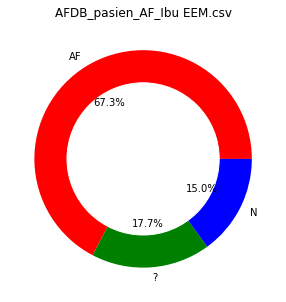

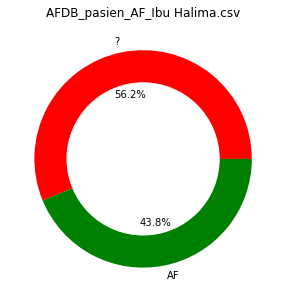

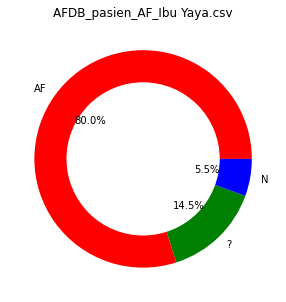

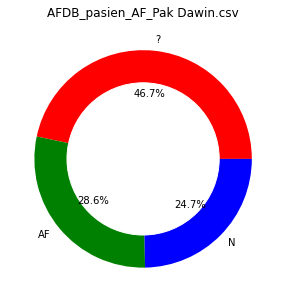

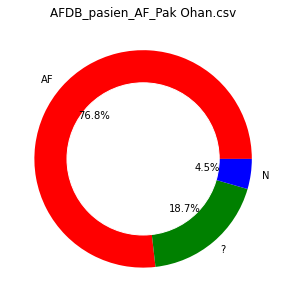

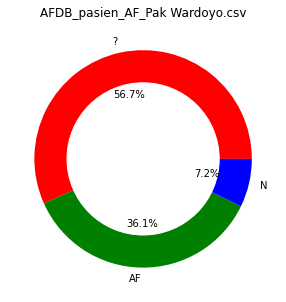

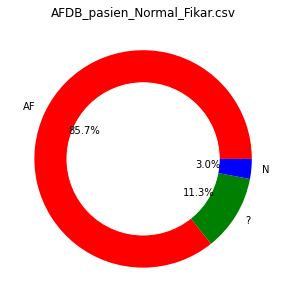

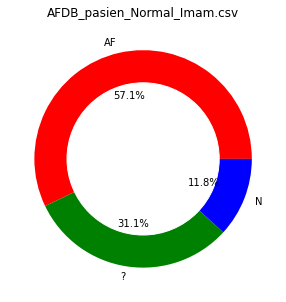

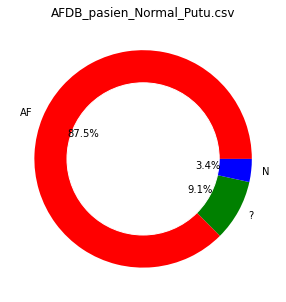

In [135]:
for name in filenames:
    count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
    plot_donat(count.values(), name, count.keys())

- save result as csv

In [111]:
pred_result_df.to_csv(dataset_folder + 'inference_result_data_pasien_AF_dan_Normal.csv')